## 데이터분석
torchvision module에서 제공하는 FashionMNIST를 활용해야 합니다 (전체 데이터)

In [1]:
#!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
#%pip install torchvision
#%pip install torchinfo
#%pip install pytorchcv
# 파이토치를 이용 

import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import pytorchcv
import torch
from torch import optim
import torch.nn.functional as F

from pytorchcv import load_fashion_mnist,train_epoch, validate, train, train_long, plot_results, plot_convolution, display_dataset, check_image, check_image_dir, common_transform, plot_history
load_fashion_mnist(batch_size=128)
# torchvision module에서 제공하는 FashionMNIST를 활용하기 위하여 불러옴

이미지 데이터의 형태와 클레스 레이블을 시각적으로 탐색하고 분석

Train dataset size: 60000
Test dataset size: 10000
Number of classes: 10
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


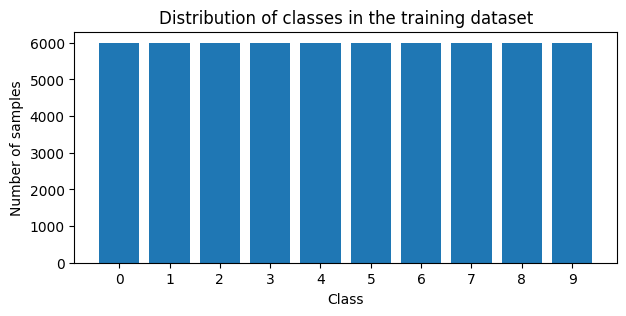

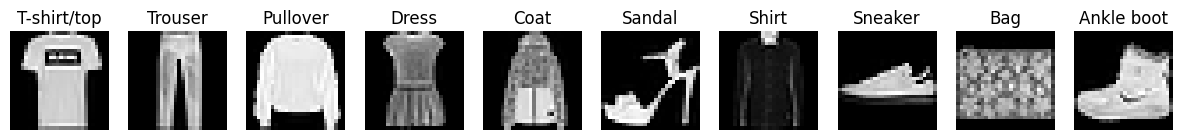

In [2]:
# 데이터셋의 형태 살펴보기
print("Train dataset size:", len(data_train))  # 훈련 데이터셋 크기 출력
print("Test dataset size:", len(data_test))    # 테스트 데이터셋 크기 출력
print("Number of classes:", len(data_train.classes))  # 클래스 수 출력
print("Classes:", data_train.classes)          # 클래스 레이블 출력

# 클래스별 데이터 분포 확인하기
class_counts = {}
for label in data_train.targets.numpy():
    class_counts[label] = class_counts.get(label, 0) + 1

plt.figure(figsize=(7, 3))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Distribution of classes in the training dataset')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.xticks(list(class_counts.keys()))
plt.show()

# 이미지 샘플 시각화
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
sample_indices = [1,16,7,3,22,9,33,6,23,0]  # 각 클래스별로 몇 가지 이미지를 선택
# 티셔츠부터 언클부츠 까지
num_classes = len(classes)

plt.figure(figsize=(15, 5 * num_classes))
for i, idx in enumerate(sample_indices):
    plt.subplot(num_classes, len(sample_indices), i + 1)
    plt.imshow(data_train[idx][0].permute(1, 2, 0), cmap='gray')  # 이미지 픽셀 값 시각화
    plt.title(classes[data_train[idx][1]])  # 이미지 클래스 레이블 출력
    plt.axis('off')  # 축 제거
plt.show()


이미지 데이터들의 형태를 확인한다.

## Convolutional Filter

임의의 convolutional Filter 를 적용하여 이미지를 확인해보기

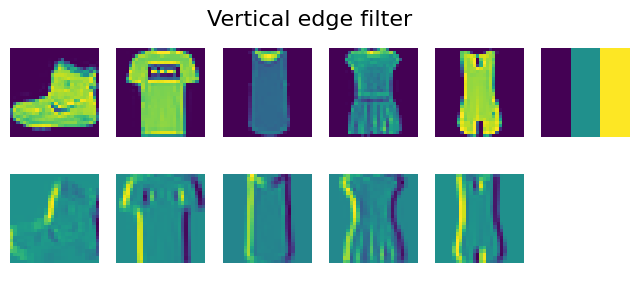

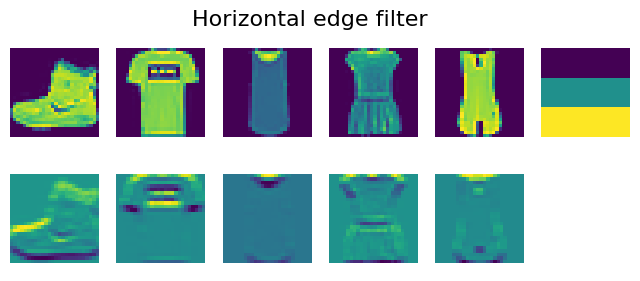

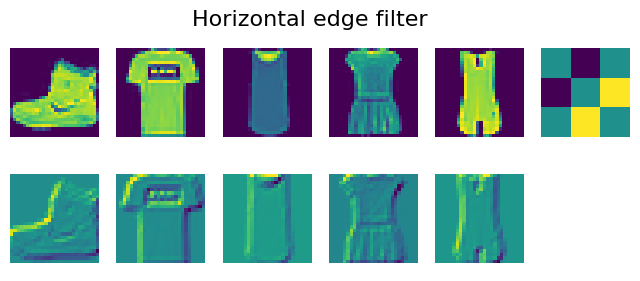

In [3]:
#Convalution filter

# 수직 에지 필터
vertical_edge_filter = torch.tensor([[-1., 0., 1.],
                                     [-1., 0., 1.],
                                     [-1., 0., 1.]])
plot_convolution(vertical_edge_filter, title='Vertical edge filter')

# 수평 에지 필터
horizontal_edge_filter = torch.tensor([[-1., -1., -1.],
                                       [0., 0., 0.],
                                       [1., 1., 1.]])
plot_convolution(horizontal_edge_filter, title='Horizontal edge filter')

# 대각선 에지 필터
diagonal_edge_filter = torch.tensor([[0., -1., 0.],
                                       [-1., 0., 1.],
                                       [0., 1., 0.]])
plot_convolution(diagonal_edge_filter, title='Horizontal edge filter')

## 모델 구축 및 훈련

Convolutional Layer

간단한 CNN 모델 구축

In [4]:
import torch.nn as nn
%pip install torchsummary
from torchsummary import summary

class OneConv(nn.Module): # OneConv 클래스를 정의합니다. PyTorch의 nn.Module을 상속합니다.
    def __init__(self): # 이 메서드는 OneConv 클래스를 초기화합니다. 객체가 생성될 때 호출됩니다.
        super(OneConv, self).__init__() # 이 라인은 상위 클래스(nn.Module)의 생성자를 호출합니다.
                                        # 이는 상속된 클래스를 올바르게 초기화하기 위해 필요합니다.
    ############## 컨볼루션 2D 합성곱
        self.conv = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=(5,5)) # 2D 합성곱 레이어를 정의합니다.
                                                                               # 입력 채널: 1, 출력 채널: 9, 커널 크기: (5,5)
        self.flatten = nn.Flatten() # Flatten 레이어의 인스턴스를 생성합니다.
                                     # 이 레이어는 다차원 입력을 1차원 배열로 변환합니다.
        self.fc = nn.Linear(5184, 10) # 5184개의 입력 특성을 10개의 출력 특성으로 변환하는 완전히 연결된 레이어를 정의합니다.

    def forward(self, x): # forward 메서드는 네트워크의 순전파를 정의합니다. x는 입력 텐서입니다.
        if x.dim() == 5 and x.size(2) == 1:  # 추가적인 차원이 있는지 확인합니다.
            x = x.squeeze(2) # 만약 존재한다면 해당 차원을 제거합니다.
        x = nn.functional.relu(self.conv(x)) # 입력 x에 합성곱 레이어 self.conv를 적용한 후 ReLU 활성화 함수를 적용합니다.
        x = self.flatten(x) # ReLU 활성화 함수의 출력을 평탄화합니다.
        x = nn.functional.log_softmax(self.fc(x), dim=1) # 평탄화된 벡터 x에 완전히 연결된 레이어 self.fc를 적용한 후 log softmax 함수를 적용합니다.
                                                         # dim=1은 softmax를 두 번째 차원(클래스에 대한 확률)을 따라 적용하도록 지정합니다.

        return x  # 처리된 텐서 x를 반환합니다. 이는 클래스의 로그 확률을 포함하며, 이는 모델 가중치를 업데이트하는 데 사용됩니다.

# 네트워크의 인스턴스를 생성합니다.
model = OneConv()

# 모델의 요약을 출력합니다.
summary(model, input_size=(1,1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\82104\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


1번 모델을 학습하고 학습하는 과정에서 Train/Test 에 대한 Loss, Acc 값을 확인

훈련 과정에서의 손실과 정확도 모니터링

Epoch 1/5: Train Loss: 0.0040, Train Acc: 82.56%, Test Loss: 0.0033, Test Acc: 85.53%
Epoch 2/5: Train Loss: 0.0028, Train Acc: 87.46%, Test Loss: 0.0030, Test Acc: 86.32%
Epoch 3/5: Train Loss: 0.0025, Train Acc: 88.72%, Test Loss: 0.0028, Test Acc: 87.18%
Epoch 4/5: Train Loss: 0.0023, Train Acc: 89.45%, Test Loss: 0.0027, Test Acc: 87.72%
Epoch 5/5: Train Loss: 0.0022, Train Acc: 90.07%, Test Loss: 0.0027, Test Acc: 87.86%


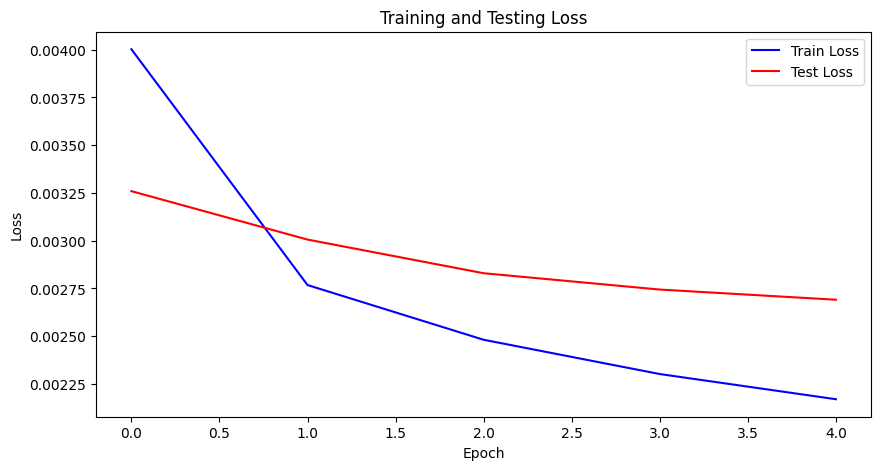

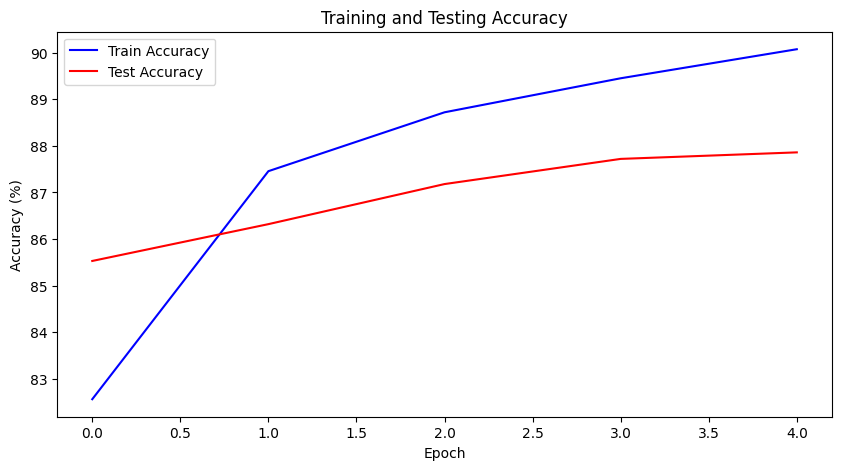

In [5]:
import matplotlib.pyplot as plt

# train 함수를 사용하여 모델을 학습하고 히스토리를 얻습니다.
history = train(model, train_loader, test_loader, epochs=5)

# 반환된 히스토리를 시각화합니다.
if history is not None:
    plot_history(history)

## 2번째 CNN 모델


pooling layer 사용한 2번째 CNN 모델 구축

In [15]:
import torch
import torch.nn as nn
from torchsummary import summary

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = nn.Linear(16 * 14 * 14, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 14 * 14)  # Flatten
        x = self.fc(x)
        return x

# 모델 생성
model_SimpleCNN = SimpleCNN()

# 모델의 요약 출력
summary(model_SimpleCNN, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Linear-3                   [-1, 10]          31,370
Total params: 31,530
Trainable params: 31,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.12
Estimated Total Size (MB): 0.24
----------------------------------------------------------------


1번 모델과 2번 모델의 성능 비교

Epoch 1/5: Train Loss: 0.0042, Train Acc: 81.78%, Test Loss: 0.0033, Test Acc: 85.20%
Epoch 2/5: Train Loss: 0.0028, Train Acc: 87.33%, Test Loss: 0.0030, Test Acc: 86.38%
Epoch 3/5: Train Loss: 0.0025, Train Acc: 88.45%, Test Loss: 0.0029, Test Acc: 87.05%
Epoch 4/5: Train Loss: 0.0024, Train Acc: 89.17%, Test Loss: 0.0028, Test Acc: 87.58%
Epoch 5/5: Train Loss: 0.0023, Train Acc: 89.70%, Test Loss: 0.0027, Test Acc: 87.99%


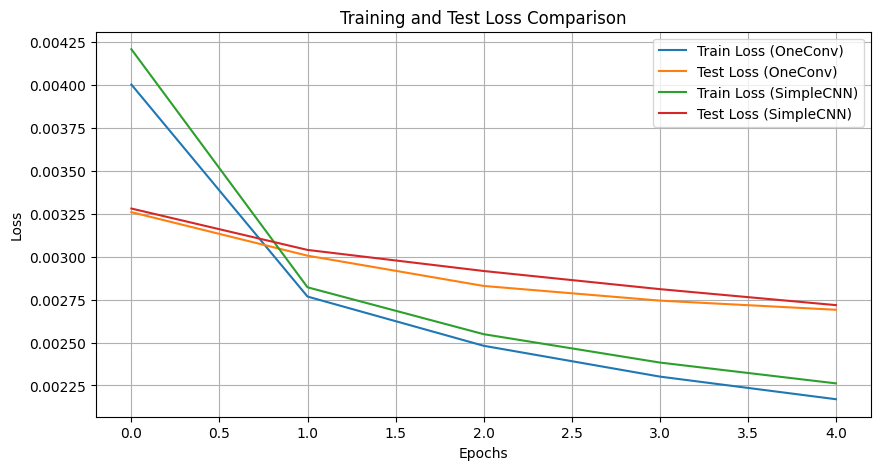

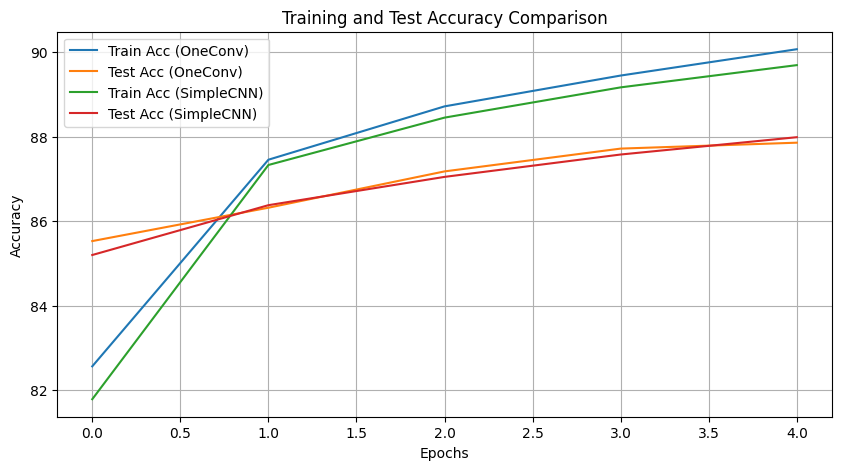

In [8]:
# 모델 초기화
model_1 = OneConv()
model_2 = SimpleCNN()


# history_1 = train(model_1, train_loader, test_loader, epochs=5)
history_2 = train(model_2, train_loader, test_loader, epochs=5)


# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss (OneConv)')
plt.plot(history['test_loss'], label='Test Loss (OneConv)')
plt.plot(history_2['train_loss'], label='Train Loss (SimpleCNN)')
plt.plot(history_2['test_loss'], label='Test Loss (SimpleCNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train Acc (OneConv)')
plt.plot(history['test_acc'], label='Test Acc (OneConv)')
plt.plot(history_2['train_acc'], label='Train Acc (SimpleCNN)')
plt.plot(history_2['test_acc'], label='Test Acc (SimpleCNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

시행 할때마다 순위가 달라짐 >> 성능 차이가 없음,
따라서 평가분석은 기존의 OneConv model을 사용

## 평가 분석

최종 정확도를 표시하고

잘못 분류된 이미지들 분석

In [14]:
def evaluate_model(model, test_loader, device):
    model.eval()  # 모델을 평가 모드로 전환합니다.

    correct = 0
    total = 0
    confusion_matrix = torch.zeros(num_classes, num_classes).to(device)  # 혼동 행렬을 선택한 장치로 이동합니다.

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # 선택한 장치로 데이터를 이동합니다.

            outputs = model(images)  # 모델로부터 예측값을 얻습니다.
            _, predicted = torch.max(outputs, 1)  # 가장 높은 확률을 가진 클래스를 선택합니다.

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 혼동 행렬 업데이트
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    accuracy = correct / total  # 정확도 계산
    print('Accuracy on test set: {:.4f}'.format(accuracy))
    ## 최종적으로 나온 첫번째 모델의 Test Accuracy 를 출력
    
    return accuracy, confusion_matrix

# 모델 평가
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 사용 가능 여부에 따라 장치 선택
accuracy, confusion_matrix = evaluate_model(model, test_loader, device)
print('Confusion Matrix:')
print(confusion_matrix)
# 혼돈 행렬을 통해 오류를 시각적으로 파악

Accuracy on test set: 0.8786
Confusion Matrix:
tensor([[913.,   0.,  17.,  16.,   5.,   2.,  37.,   0.,  10.,   0.],
        [  9., 963.,   1.,  20.,   2.,   0.,   2.,   0.,   3.,   0.],
        [ 21.,   0., 844.,   8.,  75.,   0.,  47.,   0.,   5.,   0.],
        [ 42.,   2.,  16., 887.,  31.,   0.,  18.,   0.,   4.,   0.],
        [  2.,   1.,  76.,  27., 841.,   0.,  48.,   0.,   5.,   0.],
        [  0.,   0.,   0.,   1.,   0., 943.,   0.,  28.,   1.,  27.],
        [259.,   1., 105.,  19.,  92.,   0., 510.,   0.,  14.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   7.,   0., 937.,   0.,  56.],
        [  4.,   0.,   4.,   2.,   2.,   2.,   7.,   5., 974.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   2.,   0.,  23.,   1., 974.]])


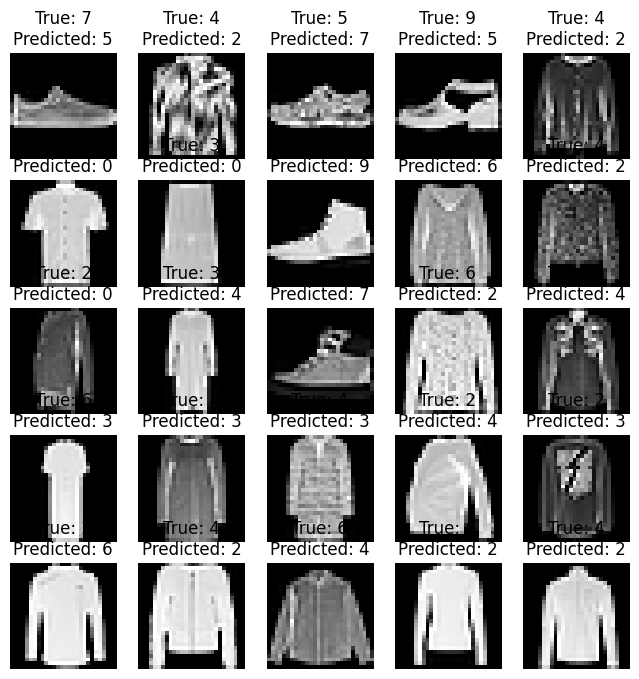

In [11]:
def evaluate_model(model, test_loader):
    model.eval()  # 모델을 평가 모드로 설정
    misclassified_images = []  # 잘못 분류된 이미지를 저장할 리스트

    with torch.no_grad():  # 그라디언트 계산 비활성화
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            incorrect_idx = (predicted != labels).nonzero()[:, 0]  # 잘못 분류된 이미지의 인덱스 추출

            # 잘못 분류된 이미지를 저장
            for idx in incorrect_idx:
                misclassified_images.append((images[idx], labels[idx], predicted[idx]))

    return misclassified_images

# 모델 평가 및 잘못 분류된 이미지 확인
misclassified_images = evaluate_model(model, test_loader)

# 잘못 분류된 이미지 시각화 
plt.figure(figsize=(8, 8))
for i, (image, true_label, predicted_label) in enumerate(misclassified_images[:25]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image.cpu().numpy().squeeze(), cmap='gray')
    plt.title(f'True: {true_label.item()}\nPredicted: {predicted_label.item()}')
    plt.axis('off')
plt.show()

어떤 클래스가 가장 잘못 분류되었는지 그래프로 확인

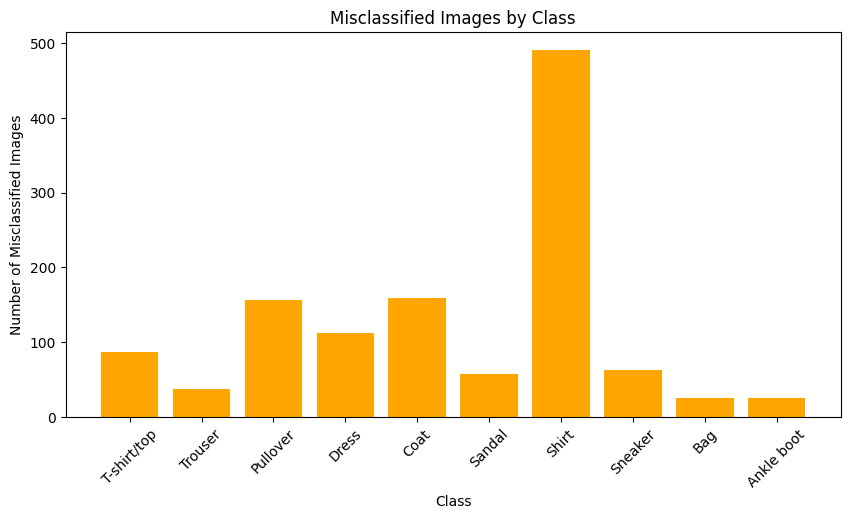

In [12]:
# 모델의 테스트 결과를 사용하여 실제 레이블과 예측된 레이블을 가져옵니다.
true_labels = []
predicted_labels = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

# 각 클래스별로 잘못 분류된 이미지 수를 계산합니다.
misclassified_counts = {class_name: 0 for class_name in classes}
for true_label, predicted_label in zip(true_labels, predicted_labels):
    if true_label != predicted_label:
        misclassified_counts[classes[true_label]] += 1

# 막대 그래프로 잘못 분류된 이미지 수를 시각화합니다.
plt.figure(figsize=(10, 5))
plt.bar(misclassified_counts.keys(), misclassified_counts.values(), color='orange')
plt.title('Misclassified Images by Class')
plt.xlabel('Class')
plt.ylabel('Number of Misclassified Images')
plt.xticks(rotation=45)
plt.show()

shirt 가 가장 잘못 분류된 것을 확인 할 수 있다.

아래코드에서 메트릭스로 결과를 확인 한다.

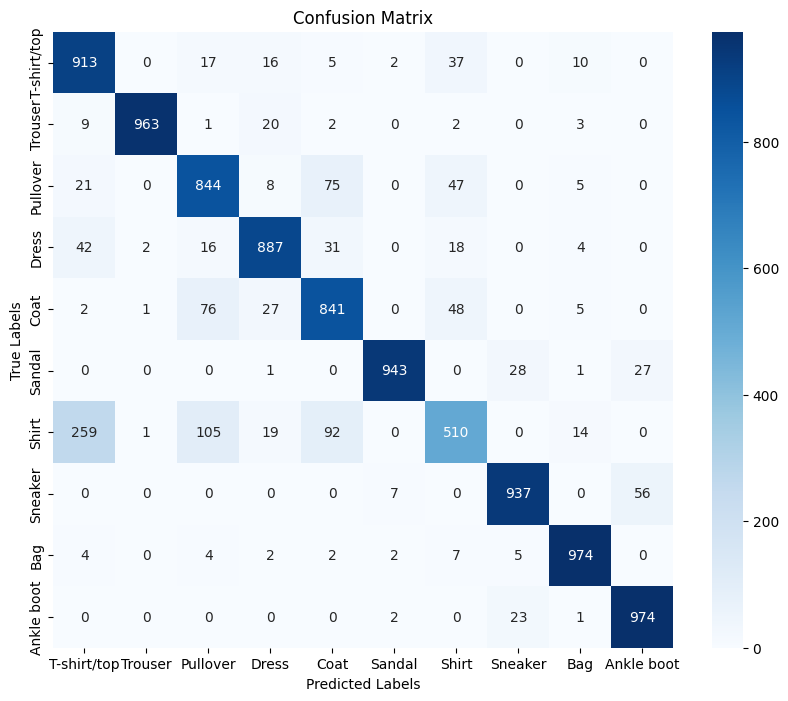

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 혼동 행렬 계산
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

shirt 를 T-shirt/top 으로 잘못 분류하는 경우가 가장 많은 것을 확인 할 수 있다.